In [14]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import sos1k_M2K as sosm2k 
import sos1k_M2K_konly as sosk

import astropy.io.fits as ft
import matplotlib.colors as cl
import scipy
from functions import *

import warnings
warnings.filterwarnings("ignore")#no warnings pls

# %matplotlib widget 


In [44]:
# Simulating points
Ny=20
Ne=20
y0s=np.linspace(.4,1.0,Ny)
ejs=np.linspace(-.75,-.5,Ne)

y0=.9
E_J=-0.6967

LZ=[]
VR=[]
for y0 in tqdm(y0s):
    for E_J in ejs:
        Lz_SNd, vr_SNd=sosk.sos1k(y0,E_J,tmax=500) #sos1k takes axs of two, y0, and E_J

        LZ.append(Lz_SNd)
        VR.append(vr_SNd)

#around 8min for 400 pts

y0_sim=y0s.copy()
ej_sim=ejs.copy()

100%|██████████| 20/20 [09:31<00:00, 28.56s/it]


In [46]:
# Constructing Covariance matrices for each data point
Gammas=[]
Gammas_inv=[]
qbars_vr=[]
qbars_lz=[]
for j in tqdm(range(len(LZ))):
    vr_SNd=VR[j]
    Lz_SNd=LZ[j]
    N=len(vr_SNd)
    if N==0:
        Gamma=np.matrix([[0,0],[0,0]])
        Gamma_inv=np.matrix([[0,0],[0,0]])
        qbars_vr.append(0)
        qbars_lz.append(0)
    else:
        qs=[]
        for i in range(N):
            qs.append(np.matrix([Lz_SNd[i],vr_SNd[i]]).T)

        qbar=np.matrix([np.mean(Lz_SNd),np.mean(vr_SNd)]).T #\bar{q}=[Lz,Vr]T
        qbars_lz.append(float(qbar[0]))
        qbars_vr.append(float(qbar[1]))

        Gamma=np.matrix([[1,2],[3,4]])
        temp=np.matrix([[0,0],[0,0]])
        for i in range(N):
            temp=temp+ qs[i]*qs[i].T
        temp=temp/N

        Gamma=temp-qbar*qbar.T
        # print(Gamma) 
        Gamma_inv=np.linalg.inv(Gamma) 
    Gammas.append(Gamma)
    Gammas_inv.append(Gamma_inv)

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:02<00:00, 163.24it/s] 


In [47]:
# Interpolating the likelihood function
g11=[]
g12=[]
g21=[]
g22=[]
for mtx in tqdm(Gammas):
    g11.append(mtx[0,0])
    g12.append(mtx[0,1])
    g21.append(mtx[1,0])
    g22.append(mtx[1,1])

x = y0_sim
y = ej_sim
Y,X=np.meshgrid(y,x)
Y=Y.flatten()
X=X.flatten()

XY = np.column_stack((X, Y))

rbffunc='linear'    #rbf kernel
rbfsm=0.01          #rbf smoothing parameter
z=g11
rbf11 = scipy.interpolate.Rbf(X, Y, z,function=rbffunc,smooth=rbfsm)

z=g12
rbf12 = scipy.interpolate.Rbf(X, Y, z,function=rbffunc,smooth=rbfsm)

z=g21
rbf21 = scipy.interpolate.Rbf(X, Y, z,function=rbffunc,smooth=rbfsm)

z=g22
rbf22 = scipy.interpolate.Rbf(X, Y, z,function=rbffunc,smooth=rbfsm)

z=qbars_lz
rbfqlz = scipy.interpolate.Rbf(X, Y, z,function=rbffunc,smooth=rbfsm)

z=qbars_vr
rbfqvr = scipy.interpolate.Rbf(X, Y, z,function=rbffunc,smooth=rbfsm)

def fGamma(y0,ej):

    f11=rbf11(y0,ej)
    f12=rbf12(y0,ej)
    f21=rbf21(y0,ej)
    f22=rbf22(y0,ej)
    return np.matrix([f11,f12],[f21,f22])

def fGamma_inv(y0,ej):

    a=rbf11(y0,ej)
    b=rbf12(y0,ej)
    c=rbf21(y0,ej)
    d=rbf22(y0,ej)
    delta=a*d-b*c
    if abs(delta)<1e-12:
        return np.matrix([[0,0],[0,0]])

    return 1/delta*np.matrix([[d,-b],[-c,a]])

def fqbar(y0,ej):
    return np.matrix([rbfqlz(y0,ej),rbfqvr(y0,ej)]).T

100%|██████████| 400/400 [00:00<?, ?it/s]


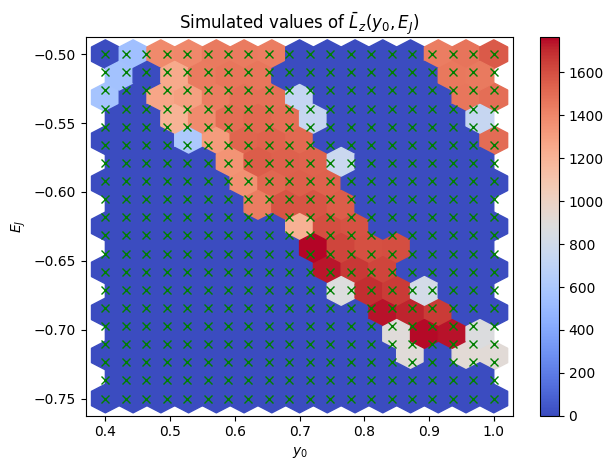

In [110]:
fig = plt.figure()

ax = plt.axes()

# Defining the z axis and interpolation function
z=np.array(qbars_lz) 
rbf=rbfqlz

# Plot it out
x = y0_sim
y = ej_sim
Y,X=np.meshgrid(y,x)
Y=Y.flatten()
X=X.flatten()

C=ax.hexbin(X,Y,z,cmap='coolwarm',gridsize=14)
plt.colorbar(C)
ax.plot(X,Y,'gx')
ax.set_title(r'Simulated values of $\bar{L}_z(y_0, E_J)$')
ax.set_xlabel('$y_0$')
ax.set_ylabel('$E_J$')

plt.tight_layout()
# plt.savefig('simulated values.jpg',dpi=500)
plt.show()




In [100]:
# Defining known periodic orbits
inis=[[1.1, -0.6967], [1.1, -0.6662], [1.0, -0.7193],
       [1.0, -0.6307], [0.9, -0.7597], 
       [0.9, -0.5796], [0.8, -0.5117], [0.7, -0.4264],
         [0.6, -0.3272], [0.5, -0.2157]] #[y0_periodic,E_J]
inis=np.array(inis)
cdt= (inis[:,0]<1) & (inis[:,1]<=-.5) & (inis[:,1]>=-.7)
inis=inis[cdt].T


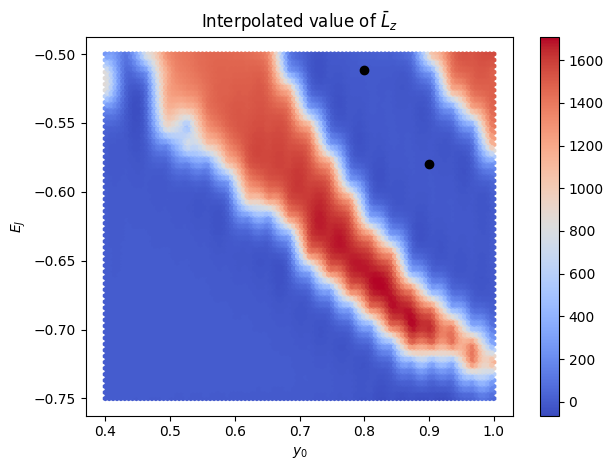

In [105]:
# defining surface and axes
N=200
N = 200
xi = np.linspace(min(y0s), max(y0s), N)
yi = np.linspace(min(ejs), max(ejs), N)
x, y = np.meshgrid(xi, yi)  

x_flat = x.flatten()
y_flat = y.flatten()

z = rbf(x_flat, y_flat)


fig = plt.figure()


ax = plt.axes()


C=ax.hexbin(x_flat,y_flat,z,cmap='coolwarm',gridsize=100)
plt.colorbar(C)
ax.set_title(r'Interpolated value of $\bar{L}_z$')
ax.set_xlabel('$y_0$')
ax.set_ylabel('$E_J$')

plt.plot(inis[0],inis[1],'ko')
plt.tight_layout()
# plt.savefig('Interpolation.jpg',dpi=500)
plt.show()


In [48]:
# defining the conditional density
def fconditional(lz,vr,y0,ej):
    #note that we need len(lz)=vr=y0=ej
        z=[]
        for i in range(len(lz)):
            q=np.matrix([lz[i],vr[i]]).T
            x=y0[i]
            y=ej[i]
            qbar=fqbar(x,y)

            fginv=fGamma_inv(x,y)
            temp=float(np.exp(-0.5*(q-qbar).T*fginv*(q-qbar)))
            if np.isnan(temp):
                temp=0
            elif np.isinf(temp):
                temp=0
            z.append(temp)

        return np.array(z)/max(z) #normalise the outcome

In [49]:
# defining the likelihood density

def likelihood(y0,ej,y_obs):
    lz=y_obs[0]
    vr=y_obs[1]
    lz=lz*np.ones_like(y0)
    vr=vr*np.ones_like(y0)

    z=fconditional(lz,vr,y0,ej)
    return z

In [106]:
# defining the prior density
Lambda=10
hr=2.15/5 # h_r = 2.15 ± 0.14 kpc (Bovy & Rix 2013) 
def prior(y0,ej):
    return np.exp(-Lambda*ej-y0/hr)
# defining the prior density

def post(y0,ej,y_obs):
    return prior(y0,ej)*likelihood(y0,ej,y_obs)

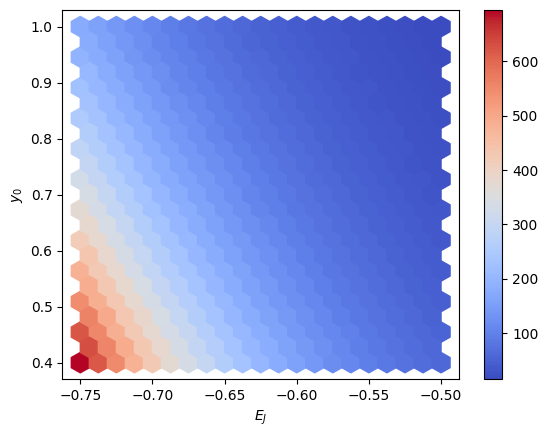

In [108]:
plt.figure()
x = np.outer(ejs,np.ones(Ne)).flatten()
y = np.outer(y0s,np.ones(Ny)).T.flatten()
z = prior(y,x)
plt.hexbin(x,y,z,cmap='coolwarm',gridsize=20,reduce_C_function=np.mean
              ,norm=cl.Normalize())
plt.colorbar()

plt.xlabel('$E_J$')
plt.ylabel('$y_0$')
# plt.savefig('Prior Density.jpg',dpi=500)
plt.show()

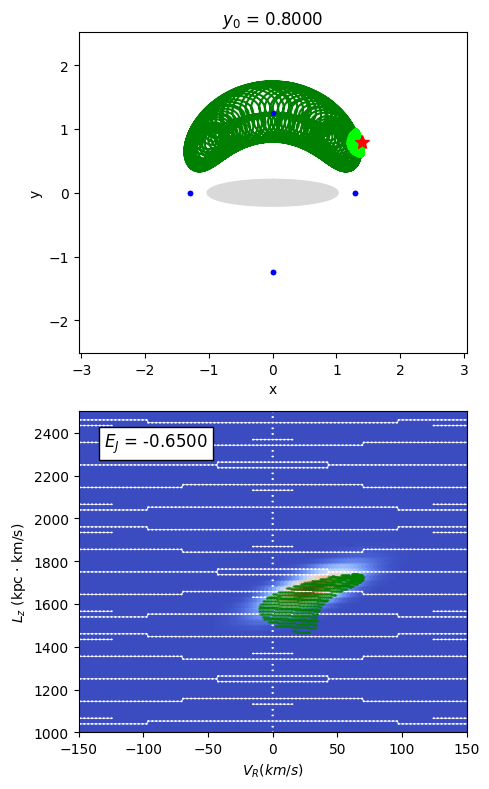

In [66]:
# Test the conditional density

fig,axs = plt.subplots(2,1,figsize=(5,8))
axs = axs.flatten()

N=100
y0=.8
ej=-0.65

x = np.outer(np.linspace(1000,2500, N), np.ones(N)).flatten()
y = np.outer(np.linspace(-150,150, N), np.ones(N)).T.flatten()

Y_0=y0*np.ones_like(x)
E_J=ej*np.ones_like(x)
z = fconditional(x,y,Y_0,E_J)
ax=axs[-1]
ax.hexbin(y,x,z,cmap='coolwarm')

ax=axs[-1]
picrange=[[-150,150],[1000, 2500]]

ax.set_xlabel(r'$V_{R} (km/s)$')
ax.set_ylabel(r'$L_z$ (kpc $\cdot$ km/s)')

sosm2k.sos1k(axs,y0,ej,tmax=500) #sos1k takes axs of two, y0, and E_J
plt.tight_layout()
# plt.savefig('conditional density.jpg',dpi=500) #save the figure

In [51]:
#Import GALAH DR3 data
filename='galah_vac_dynamics.fits'  #From Buder et al. (2021)
galah_dynamics=ft.open(filename)

dynamics_data=galah_dynamics[1].data
galah_dynamics.close()

neighbour_star_idx=np.loadtxt('neighbour_star_idx.csv', delimiter=',',dtype=np.int64)
ndynamics=dynamics_data[neighbour_star_idx]

In [16]:
Lz=ndynamics['L_Z']
Vr=ndynamics['vR_Rzphi']


# construct hercules star idx
hercules_idx=[]
for i in tqdm(range(len(ndynamics))):
    pt=(ndynamics['vR_Rzphi'][i],ndynamics['L_Z'][i])
    if is_hercules(pt):
        # print('yes')
        hercules_idx.append(i)

cdt_hercules=np.isin(np.arange(len(ndynamics)),hercules_idx)
cdt_hercules12= cdt_hercules & (ndynamics['L_Z']>1600)


100%|██████████| 521804/521804 [00:31<00:00, 16639.47it/s]


In [18]:
n=1000
indices=np.random.choice(range(len(Lz[cdt_hercules])), size=n, replace=False)
Lz_obs=Lz[cdt_hercules][indices]
Vr_obs=Vr[cdt_hercules][indices]#subtracting a subset of observations to test the pipeline.

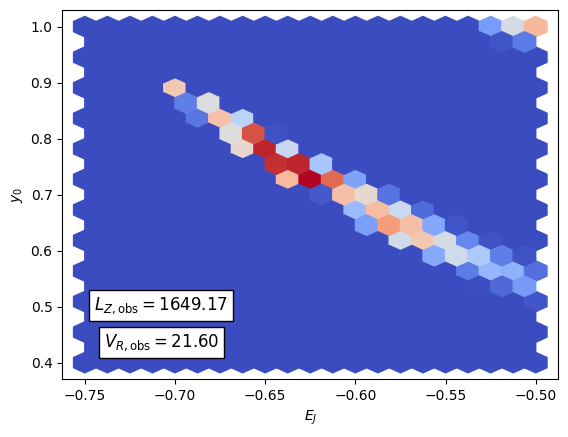

In [78]:
# Show the likelihood density of an observation
Ny=100
Ne=100
y0s=np.linspace(.4,1.0,Ny)
ejs=np.linspace(-.75,-.5,Ne)

x = np.outer(ejs,np.ones(Ne)).flatten()
y = np.outer(y0s,np.ones(Ny)).T.flatten()

i = np.random.randint(0, len(Vr_obs) + 1)  # Adding 1 to upper_bound to make it inclusive

# y_obs=(Lz_obs[i],Vr_obs[i])     #take a random observation
y_obs=(1649.1691, 21.595352)    #take a specific obsevations
z = likelihood(y,x,y_obs)

plt.figure()
hb=plt.hexbin(x,y,z,cmap='coolwarm',gridsize=20,reduce_C_function=np.median
              ,norm=cl.Normalize())
counts = hb.get_array()
bin_positions = hb.get_offsets()

plt.annotate(r'$L_{Z,\text{obs}}=$'+'{:.2f}'.format(y_obs[0]), xy=(0.2, 0.2), 
            xycoords='axes fraction', ha='center', va='center',
            bbox=dict(boxstyle='square', fc='w'),fontsize=12)
plt.annotate(r'$V_{R,\text{obs}}=$'+'{:.2f}'.format(y_obs[1]), xy=(0.2, 0.1), 
            xycoords='axes fraction', ha='center', va='center',
            bbox=dict(boxstyle='square', fc='w'),fontsize=12)
plt.xlabel('$E_J$')
plt.ylabel('$y_0$')
# plt.savefig('likelihood function.jpg',dpi=500)
plt.show()



(1649.1691, 21.595352)


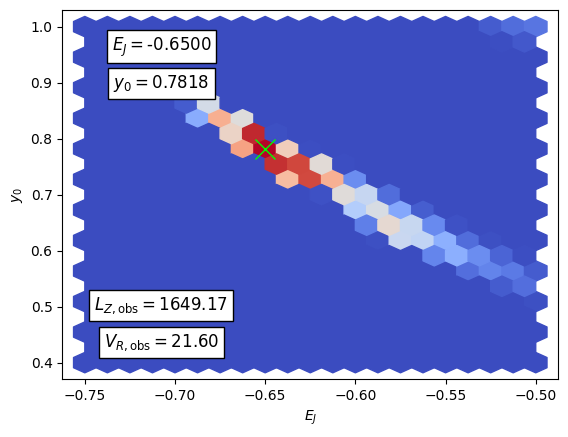

In [84]:
plt.figure()

Ny=50
Ne=50
y0s=np.linspace(.4,1.0,Ny)
ejs=np.linspace(-.75,-.5,Ne)
x = np.outer(ejs,np.ones(Ne)).flatten()
y = np.outer(y0s,np.ones(Ny)).T.flatten()


z = post(y,x,y_obs)
hb=plt.hexbin(x,y,z,cmap='coolwarm',gridsize=20,reduce_C_function=np.median
              ,norm=cl.Normalize())
# plt.colorbar()
counts = hb.get_array()
bin_positions = hb.get_offsets()
idx=np.argmax(counts)
mlx=bin_positions[idx]
Y0=mlx[1]
EJ=mlx[0]

plt.plot(EJ,Y0,'x',color='lime',markersize=15)
print(y_obs)
plt.xlabel('$E_J$')
plt.ylabel('$y_0$')
plt.annotate(r'$L_{Z,\text{obs}}=$'+'{:.2f}'.format(y_obs[0]), xy=(0.2, 0.2), 
            xycoords='axes fraction', ha='center', va='center',
            bbox=dict(boxstyle='square', fc='w'),fontsize=12)
plt.annotate(r'$V_{R,\text{obs}}=$'+'{:.2f}'.format(y_obs[1]), xy=(0.2, 0.1), 
            xycoords='axes fraction', ha='center', va='center',
            bbox=dict(boxstyle='square', fc='w'),fontsize=12)

plt.annotate(r'$E_J=$'+'{:.4f}'.format(EJ), xy=(0.2, 0.9), 
            xycoords='axes fraction', ha='center', va='center',
            bbox=dict(boxstyle='square', fc='w'),fontsize=12)
plt.annotate(r'$y_0=$'+'{:.4f}'.format(Y0), xy=(0.2, 0.8), 
            xycoords='axes fraction', ha='center', va='center',
            bbox=dict(boxstyle='square', fc='w'),fontsize=12)

# plt.savefig('Posterior Density.jpg',dpi=500)
plt.show()

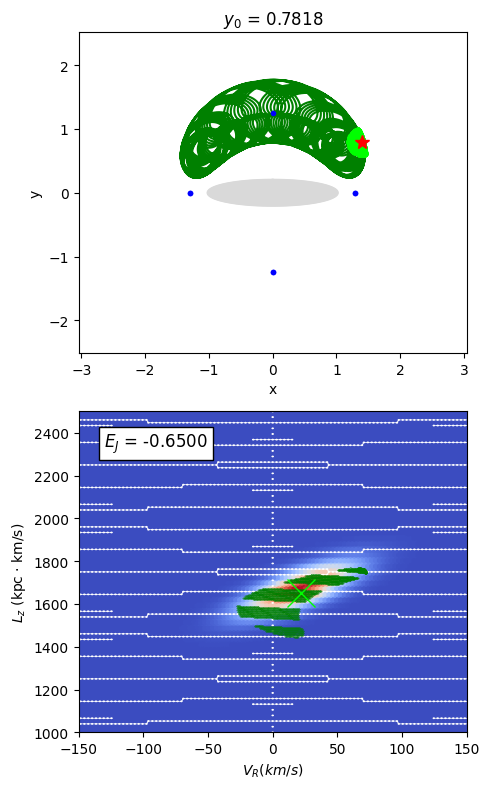

In [85]:
fig,axs = plt.subplots(2,1,figsize=(5,8))
axs = axs.flatten()
# axs[3].remove()

# defining surface and axes
N=100
y0=Y0
ej=EJ
x = np.outer(np.linspace(1000,2500, N), np.ones(N)).flatten()
y = np.outer(np.linspace(-150,150, N), np.ones(N)).T.flatten()

Y_0=y0*np.ones_like(x)
E_J=ej*np.ones_like(x)
z = fconditional(x,y,Y_0,E_J)
ax=axs[-1]
ax.hexbin(y,x,z,cmap='coolwarm')
# plt.colorbar()

ax=axs[-1]
picrange=[[-150,150],[1000, 2500]]

ax.plot(y_obs[1],y_obs[0],'x',color='lime',zorder=50,markersize=20)
ax.set_xlabel(r'$V_{R} (km/s)$')
ax.set_ylabel(r'$L_z$ (kpc $\cdot$ km/s)')

sosm2k.sos1k(axs,y0,ej,tmax=500) #sos1k takes axs of two, y0, and E_J

plt.tight_layout()
# plt.savefig('posterior result.jpg',dpi=500)

In [ ]:
# Now we go through all observations
Lz_obs=Lz[cdt_hercules]
Vr_obs=Vr[cdt_hercules]

Ny=50
Ne=50
y0s=np.linspace(.4,1.0,Ny)
ejs=np.linspace(-.75,-.5,Ne)

x = np.outer(ejs,np.ones(Ne)).flatten()
y = np.outer(y0s,np.ones(Ny)).T.flatten()


y0list=[]
ejlist=[]
for i in tqdm(range(len(Vr_obs))):
    y_obs=(Lz_obs[i],Vr_obs[i])
    z = likelihood(y,x,y_obs)
    hb=plt.hexbin(x,y,z,cmap='coolwarm',gridsize=20,reduce_C_function=np.median
              ,norm=cl.Normalize())
    counts = hb.get_array()
    bin_positions = hb.get_offsets()

    idx=np.argmax(counts)
    mlx=bin_positions[idx]
    Y0=mlx[1]
    EJ=mlx[0]
    y0list.append(Y0)
    ejlist.append(EJ)

plt.show()



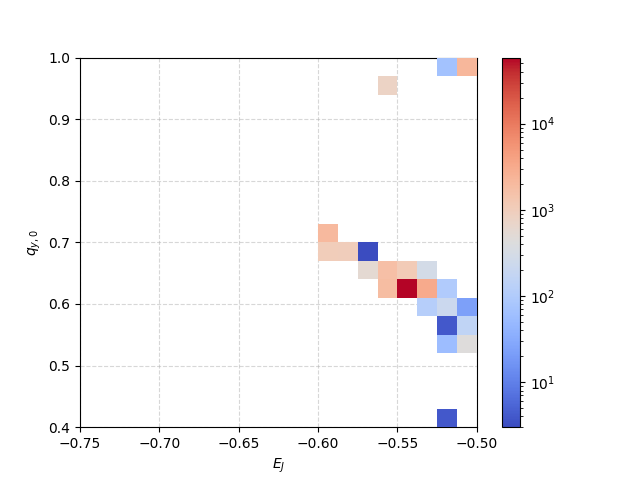

In [323]:
plt.figure()
hist,xedges,yedges,_=plt.hist2d(ejlist,y0list,bins=20,cmap='coolwarm'
           ,range=[[-.75,-.5],[.4,1.0]]
           ,norm=cl.LogNorm()
           ,zorder=10
           )
plt.grid(linestyle='--',alpha=.5,zorder=1)
plt.colorbar()
plt.xlabel(r'$E_J$')
plt.ylabel(r'$q_{y,0}$')
# plt.savefig('GALAH-inversion.jpg',dpi=500)
plt.show()